In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint as odeint_torch
from generate_data import generate_data
from tqdm import tqdm
from functorch import make_functional
from utils import  extract_and_reset_grads
import time
import gc
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

In [17]:
# NN correction
class ClosureTerm(torch.nn.Module):
    def __init__(self, params):
        super(ClosureTerm, self).__init__()
        # params of the neural correction to the dynamical model (FCN model)
        self.trans_layers = params['transition_layers']
        self.transLayers = torch.nn.ModuleList([torch.nn.Linear(params['dim_state'], params['dim_hidden_dyn_mdl'])])
        self.transLayers.extend(
            [torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_hidden_dyn_mdl']) for i in
             range(1, params['transition_layers'])])
        self.out_transLayers = torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_state'])   
    
    def forward(self, x):
        for i in range(self.trans_layers):
            x = torch.tanh(self.transLayers[i](x))
        x = self.out_transLayers(x)
        return x

In [18]:
# "hybrid model"
class HybridMdl(torch.nn.Module):
    def __init__(self, params):
        super(HybridMdl, self).__init__()
        # dimensions :
        self.dim_state = params['dim_state']
        self.closure = ClosureTerm(params).to(params['device'])
        # params of the true L63 system
        self.sigma = torch.from_numpy(np.array(GD.parameters.sigma)).float().to(params['device'])
        self.rho = torch.from_numpy(np.array(GD.parameters.rho)).float().to(params['device'])
        self.beta = torch.from_numpy(np.array(GD.parameters.beta)).float().to(params['device'])
        self.nfe = 0
    def dyn_net(self, t, inp):
        self.nfe+=1
        grad = (torch.zeros((inp.size())).to(inp.device))
        grad[:,0] = self.sigma*(inp[:,1]-inp[:,0]);
        grad[:,1] = inp[:,0]*(self.rho-inp[:,2])-inp[:,1];
        grad[:,2] = inp[:,0]*inp[:,1] #+  self.beta*inp[:,2];
        return grad + self.closure(inp)

    def model_dt(self, inp, dt, t0=0,
                grad_mode='EGA-static'):  # flow of the ODE, assuming the flow is autonomous so t0 is always 0
        if grad_mode == 'exact':
            self.nfe = 0
            pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt).to(inp.device), method='rk4')
            return pred[-1, :, :]
        elif grad_mode == 'EGA-static' or grad_mode == 'EGA-ST' or grad_mode == 'EGA-J':
            with torch.no_grad():
                # blackbox non diff solver, here an adaptive dopri solver
                self.nfe = 0
                pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt).to(inp.device), method='rk4')
            # computational graph of the blackbox solver
            if grad_mode == 'EGA-static':
                output_p = dt * self.closure(inp.detach()) + inp
                output_p.data = pred[-1, :, :]
            elif grad_mode == 'EGA-ST':
                output_p = dt * self.closure(inp) + inp
                output_p.data = pred[-1, :, :]
            elif grad_mode == 'EGA-J':
                output_p = dt * self.dyn_net(t0+dt,inp) + inp
                output_p.data = pred[-1, :, :]                
            return output_p
    def forward(self, dt, n, x0, grad_mode='EGA'):
        pred = [x0]
        for i in range(n):
            pred.append(self.model_dt(pred[-1], dt, grad_mode=grad_mode))
        pred_seq = torch.stack(pred)[:, :, :]
        return pred_seq

In [19]:
convergence_diag = {'n_steps': [25,30,35,40,45],'time_steps': [0.01],'error_EGA_ST': [], 'error_EGA_Static': [], 'error_EGA_J_Euler': [], 'norm_error_EGA_ST': [], 'norm_error_EGA_Static': [], 'norm_error_EGA_J_Euler': [], 'time_comp_graph': [], 'time_EGA_static': [], 'time_EGA_J_Euler': [], 'time_EGA_ST': [], 'mem_comp_graph': [], 'mem_EGA_static': [], 'mem_EGA_J_Euler': [], 'mem_EGA_ST': [], 'mem_forward_comp_graph': [], 'mem_forward_EGA_static': [], 'mem_forward_EGA_J_Euler': [], 'mem_forward_EGA_ST': [], 'nfe': []}

In [20]:
# Generate Lorenz 63 simulations
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = convergence_diag['time_steps'][0]
    nb_loop_data = 60.0

# run the data generation
dataset = generate_data(GD)

In [21]:
import torch
from tqdm import tqdm
import numpy as np
import time
import gc

for i in tqdm(range(len(convergence_diag['n_steps']))):
    params = {'dt_integration': convergence_diag['time_steps'][0], 'dim_state': 3, 'dim_output': 3, 'transition_layers': 2,
              'dim_hidden_dyn_mdl': 3, 'device': 'cuda', 'Batch_size': 128, 
              'seed': 0, 'n_steps': convergence_diag['n_steps'][i]}
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    
    # make sure we use the same number of initial conditions per time resolution
    rat_data = int(convergence_diag['time_steps'][-1]/params['dt_integration'])
    subsampling = int(params['dt_integration']/convergence_diag['time_steps'][0])
    X_train = torch.from_numpy(dataset[::subsampling][::rat_data]).float()
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=params['Batch_size'], shuffle=False, pin_memory=False, drop_last=True)
    
    # hybrid model
    hybrid_model = HybridMdl(params)

    # EGA static
    time_batch_ega_static, grads_EGA_Static, mem_ega_static, mem_forward_ega_static = [], [], [], []
    time_batch_ega_J_euler, grads_EGA_J_Euler, mem_ega_J_euler, mem_forward_ega_J_euler = [], [], [], []
    time_batch_ega_ST, grads_EGA_ST, mem_ega_ST, mem_forward_ega_ST = [], [], [], []
    time_batch_comp_G, grads_GT, mem_comp_G, mem_forward_ega_comp_G = [], [], [], []
    nfe_batch = []
    
    
    for x_data in train_loader:
        x_data = x_data.to(params['device'])

        # EGA static
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_forward_ega_static = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        with torch.no_grad():
            pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-static')
            nfe_batch.append(hybrid_model.nfe)
            print(hybrid_model.nfe)
            hybrid_model.nfe = 0
        torch.cuda.synchronize()
        end_mem_forward_ega_static = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        # Clean up
        del pred_mdl
        torch.cuda.empty_cache()
        gc.collect()   
        mem_forward_ega_static.append(end_mem_forward_ega_static - start_mem_forward_ega_static)
        
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_ega_static = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-static')
        torch.cuda.synchronize()
        end_mem_ega_static = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_static = time.time()
        error1.backward()
        end_time_ega_static = time.time()
        
        time_batch_ega_static.append(end_time_ega_static - start_time_ega_static)
        mem_ega_static.append(end_mem_ega_static - start_mem_ega_static)  # Corrected memory usage calculation
        grads_EGA_Static.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())
        
        # Clean up
        del pred_mdl, error1
        torch.cuda.empty_cache()
        gc.collect()

        # EGA Jacobian Euler
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_forward_ega_J_euler = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        with torch.no_grad():
            pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-J')
        torch.cuda.synchronize()
        end_mem_forward_ega_J_euler = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        # Clean up
        del pred_mdl
        torch.cuda.empty_cache()
        gc.collect()   
        mem_forward_ega_J_euler.append(end_mem_forward_ega_J_euler - start_mem_forward_ega_J_euler)
        
        
        
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_ega_J_euler = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-J')
        torch.cuda.synchronize()
        end_mem_ega_J_euler = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_J_euler = time.time()
        error1.backward()
        end_time_ega_J_euler = time.time()
        
        time_batch_ega_J_euler.append(end_time_ega_J_euler - start_time_ega_J_euler)
        mem_ega_J_euler.append(end_mem_ega_J_euler - start_mem_ega_J_euler)  # Corrected memory usage calculation
        grads_EGA_J_Euler.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())
        
        # Clean up
        del pred_mdl, error1
        torch.cuda.empty_cache()
        gc.collect()

        # EGA straight through (keep the jacobian term of the NN model)
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_forward_ega_ST = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        with torch.no_grad():
            pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-ST')
        torch.cuda.synchronize()
        end_mem_forward_ega_ST = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        # Clean up
        del pred_mdl
        torch.cuda.empty_cache()
        gc.collect()   
        mem_forward_ega_ST.append(end_mem_forward_ega_ST - start_mem_forward_ega_ST)
        
                
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_ega_ST = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-ST')
        torch.cuda.synchronize()
        end_mem_ega_ST = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_ST = time.time()
        error1.backward()
        end_time_ega_ST = time.time()
        
        time_batch_ega_ST.append(end_time_ega_ST - start_time_ega_ST)
        mem_ega_ST.append(end_mem_ega_ST - start_mem_ega_ST)  # Corrected memory usage calculation
        grads_EGA_ST.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())
        
        # Clean up
        del pred_mdl, error1
        torch.cuda.empty_cache()
        gc.collect()

        # Exact gradient of the solver
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_forward_ega_comp_G = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        with torch.no_grad():
            pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='exact')
        torch.cuda.synchronize()
        end_mem_forward_ega_comp_G = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        # Clean up
        del pred_mdl
        torch.cuda.empty_cache()
        gc.collect()   
        mem_forward_ega_comp_G.append(end_mem_forward_ega_comp_G - start_mem_forward_ega_comp_G)
        
        
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        start_mem_comp_G = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='exact')
        torch.cuda.synchronize()
        end_mem_comp_G = torch.cuda.memory_allocated() if params['device'] == 'cuda' else 0
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_comp_G = time.time()
        error1.backward()
        end_time_ega_comp_G = time.time()
        
        time_batch_comp_G.append(end_time_ega_comp_G - start_time_ega_comp_G)
        mem_comp_G.append(end_mem_comp_G - start_mem_comp_G)  # Corrected memory usage calculation
        grads_GT.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())
        
        # Clean up
        del pred_mdl, error1
        torch.cuda.empty_cache()
        gc.collect()
    
    convergence_diag['nfe'].append(np.array(nfe_batch))
    
    # compute gradient errors
    convergence_diag['error_EGA_ST'].append(np.array(grads_GT) - np.array(grads_EGA_ST)) 
    convergence_diag['error_EGA_Static'].append(np.array(grads_GT) - np.array(grads_EGA_Static)) 
    convergence_diag['error_EGA_J_Euler'].append(np.array(grads_GT) - np.array(grads_EGA_J_Euler)) 

    norm_grad = np.abs(np.array(grads_GT))
    norm_grad[np.where(np.abs(np.array(grads_GT))<1E-3)] = np.nan
    convergence_diag['norm_error_EGA_ST'].append(np.abs(np.array(grads_GT) - np.array(grads_EGA_ST))/norm_grad) 
    convergence_diag['norm_error_EGA_Static'].append(np.abs(np.array(grads_GT) - np.array(grads_EGA_Static))/norm_grad) 
    convergence_diag['norm_error_EGA_J_Euler'].append(np.abs(np.array(grads_GT) - np.array(grads_EGA_J_Euler))/norm_grad) 

    convergence_diag['time_comp_graph'].append(np.array(time_batch_comp_G)) 
    convergence_diag['time_EGA_static'].append(np.array(time_batch_ega_static)) 
    convergence_diag['time_EGA_J_Euler'].append(np.array(time_batch_ega_J_euler)) 
    convergence_diag['time_EGA_ST'].append(np.array(time_batch_ega_ST)) 

    # store memory usage total
    convergence_diag['mem_comp_graph'].append(np.array(mem_comp_G))
    convergence_diag['mem_EGA_static'].append(np.array(mem_ega_static))
    convergence_diag['mem_EGA_J_Euler'].append(np.array(mem_ega_J_euler))
    convergence_diag['mem_EGA_ST'].append(np.array(mem_ega_ST))
    
    # store memory usage forward pass
    convergence_diag['mem_forward_comp_graph'].append(np.array(mem_forward_ega_comp_G))
    convergence_diag['mem_forward_EGA_static'].append(np.array(mem_forward_ega_static))
    convergence_diag['mem_forward_EGA_J_Euler'].append(np.array(mem_forward_ega_J_euler))
    convergence_diag['mem_forward_EGA_ST'].append(np.array(mem_forward_ega_ST))


  0%|          | 0/5 [00:00<?, ?it/s]

4
4
4


  0%|          | 0/5 [00:04<?, ?it/s]

KeyboardInterrupt



In [ ]:
0/np.nan

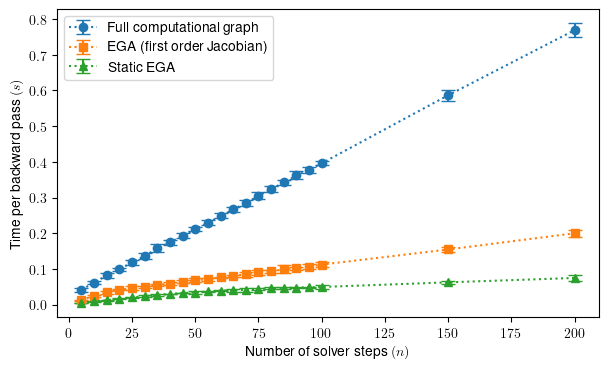

In [78]:
# Compute means and standard deviations
n_steps = convergence_diag['n_steps']
time_comp_graph = np.array(convergence_diag['time_comp_graph'])
time_EGA_J_Euler = np.array(convergence_diag['time_EGA_J_Euler'])
time_EGA_static = np.array(convergence_diag['time_EGA_static'])

mean_comp_graph = time_comp_graph.mean(axis=-1)
std_comp_graph = time_comp_graph.std(axis=-1)

mean_EGA_J_Euler = time_EGA_J_Euler.mean(axis=-1)
std_EGA_J_Euler = time_EGA_J_Euler.std(axis=-1)

mean_EGA_static = time_EGA_static.mean(axis=-1)
std_EGA_static = time_EGA_static.std(axis=-1)

plt.figure(figsize=(7,4))
# Plot with error bars (dots only, no connecting lines)
plt.errorbar(n_steps, mean_comp_graph, yerr=std_comp_graph, linestyle = 'dotted', label='Full computational graph', fmt='o', capsize=5)
plt.errorbar(n_steps, mean_EGA_J_Euler, yerr=std_EGA_J_Euler, linestyle = 'dotted', label='EGA (first order Jacobian)', fmt='s', capsize=5)
plt.errorbar(n_steps, mean_EGA_static, yerr=std_EGA_static, linestyle = 'dotted', label='Static EGA', fmt='^', capsize=5)

# Add labels, title, and legend
plt.xlabel('Number of solver steps $(n)$')
plt.ylabel('Time per backward pass $(s)$')
plt.legend()

plt.savefig("output_figures/time_backward_pass.png")
plt.savefig("output_figures/time_backward_pass.svg")
plt.savefig("output_figures/time_backward_pass.pdf")
plt.show()

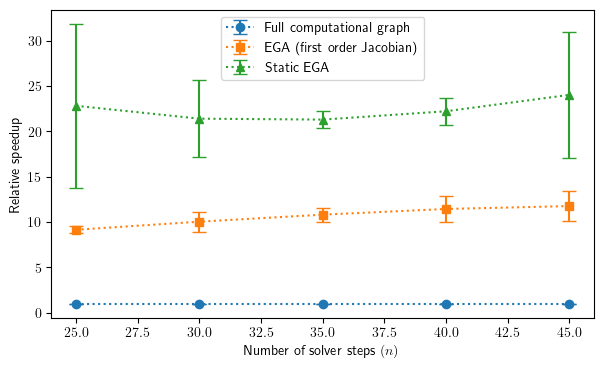

In [8]:
# Compute means and standard deviations
n_steps = convergence_diag['n_steps']
time_comp_graph = np.array(convergence_diag['time_comp_graph'])
time_EGA_J_Euler = np.array(convergence_diag['time_EGA_J_Euler'])
time_EGA_static = np.array(convergence_diag['time_EGA_static'])

time_comp_graph_speedup = time_comp_graph/time_comp_graph
time_EGA_J_Euler_speedup = time_comp_graph/time_EGA_J_Euler
time_EGA_static_speedup = time_comp_graph/time_EGA_static

mean_comp_graph = time_comp_graph_speedup.mean(axis=-1)
std_comp_graph = time_comp_graph_speedup.std(axis=-1)

mean_EGA_J_Euler = time_EGA_J_Euler_speedup.mean(axis=-1)
std_EGA_J_Euler = time_EGA_J_Euler_speedup.std(axis=-1)

mean_EGA_static = time_EGA_static_speedup.mean(axis=-1)
std_EGA_static = time_EGA_static_speedup.std(axis=-1)

plt.figure(figsize=(7,4))
# Plot with error bars (dots only, no connecting lines)
plt.errorbar(n_steps, mean_comp_graph, yerr=std_comp_graph, linestyle = 'dotted', label='Full computational graph', fmt='o', capsize=5)
plt.errorbar(n_steps, mean_EGA_J_Euler, yerr=std_EGA_J_Euler, linestyle = 'dotted', label='EGA (first order Jacobian)', fmt='s', capsize=5)
plt.errorbar(n_steps, mean_EGA_static, yerr=std_EGA_static, linestyle = 'dotted', label='Static EGA', fmt='^', capsize=5)

# Add labels, title, and legend
plt.xlabel('Number of solver steps $(n)$')
plt.ylabel('Relative speedup')
plt.legend()

plt.savefig("output_figures/Relative_speedup.png")
plt.savefig("output_figures/Relative_speedup.svg")
plt.savefig("output_figures/Relative_speedup.pdf")
plt.show()

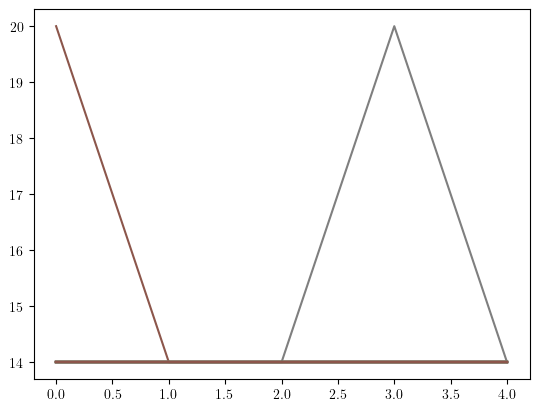

In [11]:
plt.plot(np.array(convergence_diag['nfe']))

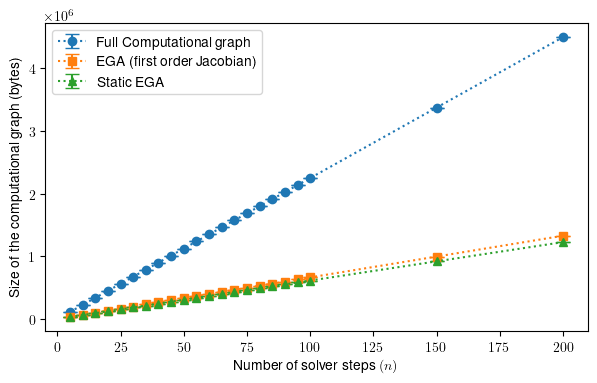

In [90]:
# Compute means and standard deviations
n_steps = convergence_diag['n_steps']
mem_comp_graph = np.array(convergence_diag['mem_comp_graph']) - np.array(convergence_diag['mem_forward_EGA_static'])
mem_EGA_J_Euler = np.array(convergence_diag['mem_EGA_J_Euler']) - np.array(convergence_diag['mem_forward_EGA_static'])
mem_EGA_static = np.array(convergence_diag['mem_EGA_static']) - np.array(convergence_diag['mem_forward_EGA_static'])

mean_comp_graph = mem_comp_graph.mean(axis=-1)
std_comp_graph = mem_comp_graph.std(axis=-1)

mean_EGA_J_Euler = mem_EGA_J_Euler.mean(axis=-1)
std_EGA_J_Euler = mem_EGA_J_Euler.std(axis=-1)

mean_EGA_static = mem_EGA_static.mean(axis=-1)
std_EGA_static = mem_EGA_static.std(axis=-1)

plt.figure(figsize=(7,4))
# Plot with error bars (dots only, no connecting lines)
plt.errorbar(n_steps, mean_comp_graph, yerr=std_comp_graph, linestyle = 'dotted', label='Full Computational graph', fmt='o', capsize=5)
plt.errorbar(n_steps, mean_EGA_J_Euler, yerr=std_EGA_J_Euler, linestyle = 'dotted', label='EGA (first order Jacobian)', fmt='s', capsize=5)
plt.errorbar(n_steps, mean_EGA_static, yerr=std_EGA_static, linestyle = 'dotted', label='Static EGA', fmt='^', capsize=5)

# Add labels, title, and legend
plt.xlabel('Number of solver steps $(n)$')
plt.ylabel('Size of the computational graph (bytes)')
plt.legend()

plt.savefig("output_figures/size_of_comp_graph.png")
plt.savefig("output_figures/size_of_comp_graph.svg")
plt.savefig("output_figures/size_of_comp_graph.pdf")
plt.show()

In [109]:
mem_EGA_J_Euler_ratio

array([[0.26898445, 0.26898445, 0.26898445, 0.26898445, 0.26898445,
        0.26898445, 0.26898445, 0.26898445, 0.26898445, 0.26898445,
        0.26898445, 0.26898445, 0.26898445, 0.26898445, 0.26898445,
        0.26898445, 0.26898445, 0.26898445, 0.26898445, 0.26898445,
        0.26898445, 0.26898445, 0.26898445, 0.26898445, 0.26898445,
        0.26898445, 0.26898445, 0.26898445, 0.26898445, 0.26898445,
        0.26898445, 0.26898445, 0.26898445, 0.26898445, 0.26898445,
        0.26898445, 0.26898445, 0.26898445, 0.26898445, 0.26898445,
        0.26898445, 0.26898445, 0.26898445, 0.26898445, 0.26898445,
        0.26898445],
       [0.26961158, 0.26961158, 0.26961158, 0.26961158, 0.26961158,
        0.26961158, 0.26961158, 0.26961158, 0.26961158, 0.26961158,
        0.26961158, 0.26961158, 0.26961158, 0.26961158, 0.26961158,
        0.26961158, 0.26961158, 0.26961158, 0.26961158, 0.26961158,
        0.26961158, 0.26961158, 0.26961158, 0.26961158, 0.26961158,
        0.26961158, 0.26961

ValueError: 'x' and 'y' must have the same size

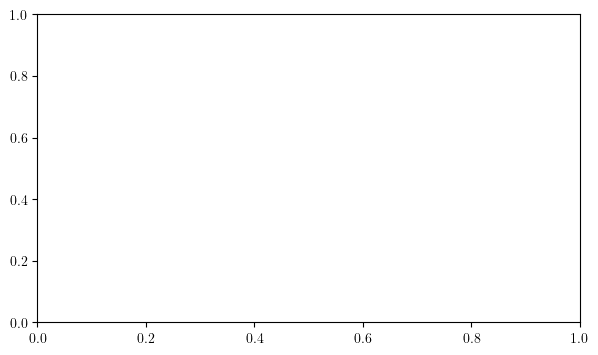

In [106]:
# Compute means and standard deviations
n_steps = convergence_diag['n_steps']
mem_comp_graph = np.array(convergence_diag['mem_comp_graph']) - np.array(convergence_diag['mem_forward_EGA_static'])
mem_EGA_J_Euler = np.array(convergence_diag['mem_EGA_J_Euler']) - np.array(convergence_diag['mem_forward_EGA_static'])
mem_EGA_static = np.array(convergence_diag['mem_EGA_static']) - np.array(convergence_diag['mem_forward_EGA_static'])

mem_comp_graph_ratio = mem_comp_graph/mem_comp_graph
mem_EGA_J_Euler_ratio = mem_EGA_J_Euler/mem_comp_graph
mem_EGA_static_ratio = mem_EGA_static/mem_comp_graph

mean_comp_graph = mem_comp_graph_ratio.mean(axis=-1)
std_comp_graph = mem_comp_graph_ratio.std(axis=-1)

mean_EGA_J_Euler = mem_EGA_J_Euler_ratio.mean(axis=-1)
std_EGA_J_Euler = mem_EGA_J_Euler_ratio.std(axis=-1)

mean_EGA_static = mem_EGA_static_ratio.mean(axis=-1)
std_EGA_static = mem_EGA_static_ratio.std(axis=-1)

plt.figure(figsize=(7,4))
# Plot with error bars (dots only, no connecting lines)
plt.errorbar(n_steps, mean_comp_graph, yerr=std_comp_graph, linestyle = 'dotted', label='Full Computational graph', fmt='o', capsize=5)
plt.errorbar(n_steps, mean_EGA_J_Euler, yerr=std_EGA_J_Euler, linestyle = 'dotted', label='EGA (first order Jacobian)', fmt='s', capsize=5)
plt.errorbar(n_steps, mean_EGA_static, yerr=std_EGA_static, linestyle = 'dotted', label='Static EGA', fmt='^', capsize=5)

# Add labels, title, and legend
plt.xlabel('Number of solver steps $(n)$')
plt.ylabel('Relative size of the computational graph')
plt.legend()

plt.savefig("output_figures/relative_size_of_comp_graph.png")
plt.savefig("output_figures/relative_size_of_comp_graph.svg")
plt.savefig("output_figures/relative_size_of_comp_graph.pdf")
plt.show()

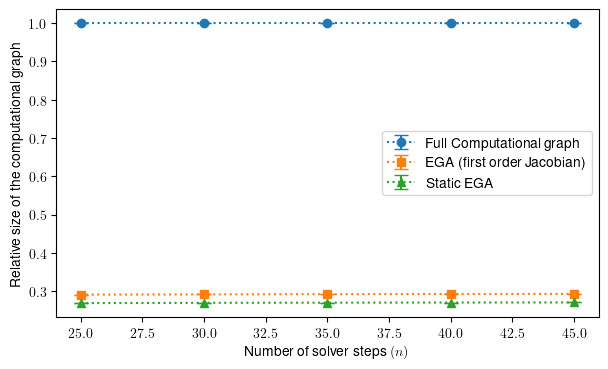

In [101]:
# Compute means and standard deviations
n_steps = convergence_diag['n_steps']
mem_comp_graph = np.array(convergence_diag['mem_comp_graph']) - np.array(convergence_diag['mem_forward_EGA_static'])
mem_EGA_J_Euler = np.array(convergence_diag['mem_EGA_J_Euler']) - np.array(convergence_diag['mem_forward_EGA_static'])
mem_EGA_static = np.array(convergence_diag['mem_EGA_static']) - np.array(convergence_diag['mem_forward_EGA_static'])

mem_comp_graph_ratio = mem_comp_graph/mem_comp_graph
mem_EGA_J_Euler_ratio = mem_EGA_J_Euler/mem_comp_graph
mem_EGA_static_ratio = mem_EGA_static/mem_comp_graph

mean_comp_graph = mem_comp_graph_ratio.mean(axis=-1)
std_comp_graph = mem_comp_graph_ratio.std(axis=-1)

mean_EGA_J_Euler = mem_EGA_J_Euler_ratio.mean(axis=-1)
std_EGA_J_Euler = mem_EGA_J_Euler_ratio.std(axis=-1)

mean_EGA_static = mem_EGA_static_ratio.mean(axis=-1)
std_EGA_static = mem_EGA_static_ratio.std(axis=-1)

plt.figure(figsize=(7,4))
# Plot with error bars (dots only, no connecting lines)
plt.errorbar(n_steps, mean_comp_graph, yerr=std_comp_graph, linestyle = 'dotted', label='Full Computational graph', fmt='o', capsize=5)
plt.errorbar(n_steps, mean_EGA_J_Euler, yerr=std_EGA_J_Euler, linestyle = 'dotted', label='EGA (first order Jacobian)', fmt='s', capsize=5)
plt.errorbar(n_steps, mean_EGA_static, yerr=std_EGA_static, linestyle = 'dotted', label='Static EGA', fmt='^', capsize=5)

# Add labels, title, and legend
plt.xlabel('Number of solver steps $(n)$')
plt.ylabel('Relative size of the computational graph')
plt.legend()

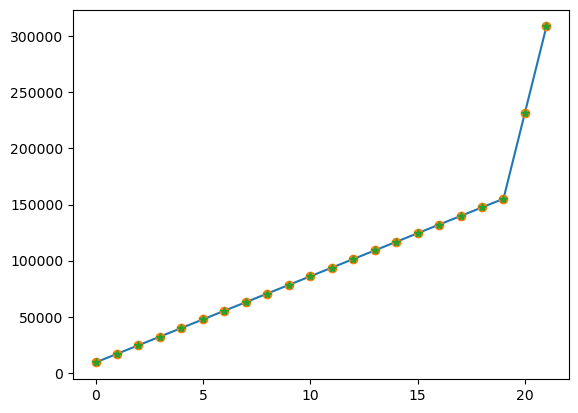

In [30]:

plt.plot(np.array(convergence_diag['mem_forward_comp_graph']).mean(axis=-1))
plt.plot(np.array(convergence_diag['mem_forward_EGA_static']).mean(axis=-1), 'o')
plt.plot(np.array(convergence_diag['mem_forward_EGA_J_Euler']).mean(axis=-1), '*')

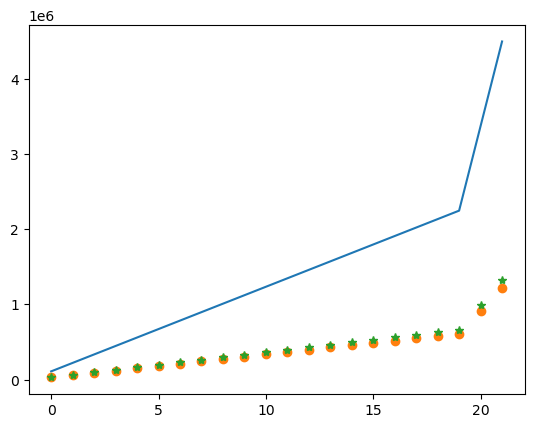

In [31]:
plt.plot(np.array(convergence_diag['mem_comp_graph']).mean(axis = -1)-np.array(convergence_diag['mem_forward_comp_graph']).mean(axis=-1))
plt.plot(np.array(convergence_diag['mem_EGA_static']).mean(axis = -1)-np.array(convergence_diag['mem_forward_EGA_static']).mean(axis=-1), 'o')
plt.plot(np.array(convergence_diag['mem_EGA_J_Euler']).mean(axis = -1)-np.array(convergence_diag['mem_forward_EGA_J_Euler']).mean(axis=-1), '*')


In [32]:
memory_backward_comp_g = np.array(convergence_diag['mem_comp_graph']).mean(axis = -1)-np.array(convergence_diag['mem_forward_comp_graph']).mean(axis=-1)
memory_backward_EGA_static = np.array(convergence_diag['mem_EGA_static']).mean(axis = -1)-np.array(convergence_diag['mem_forward_EGA_static']).mean(axis=-1)
memory_backward_EGA_J = np.array(convergence_diag['mem_EGA_J_Euler']).mean(axis = -1)-np.array(convergence_diag['mem_forward_EGA_J_Euler']).mean(axis=-1)

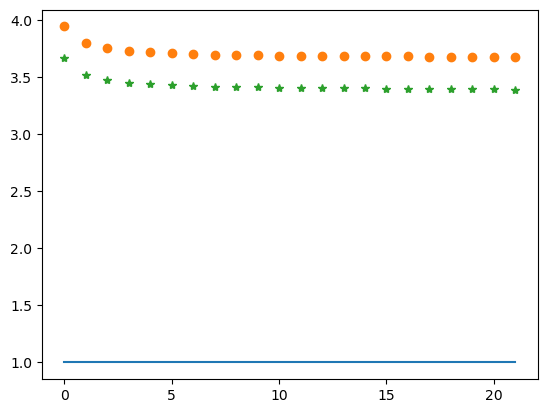

In [33]:
plt.plot(memory_backward_comp_g/memory_backward_comp_g)
plt.plot(memory_backward_comp_g/memory_backward_EGA_static, 'o')
plt.plot(memory_backward_comp_g/memory_backward_EGA_J, '*')

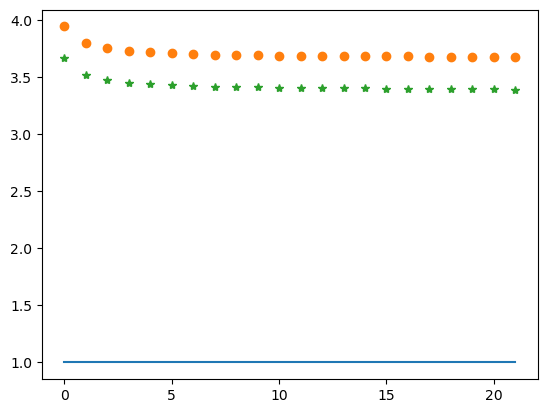

In [34]:
plt.plot(memory_backward_comp_g/memory_backward_comp_g)
plt.plot(memory_backward_comp_g/memory_backward_EGA_static, 'o')
plt.plot(memory_backward_comp_g/memory_backward_EGA_J, '*')

In [ ]:
np.abs(np.array(convergence_diag['norm_error_EGA_Static'])).mean(axis=-1).mean(axis=-1)
np.abs(np.array(convergence_diag['norm_error_EGA_Static'])).mean(axis=-1).mean(axis=-1)
np.abs(np.array(convergence_diag['norm_error_EGA_Static'])).mean(axis=-1).mean(axis=-1)

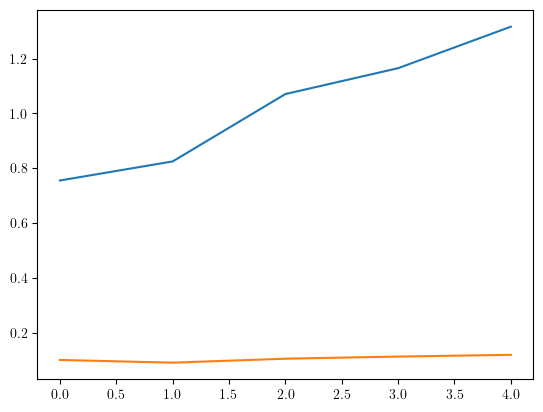

In [116]:
plt.plot(np.nanmean(np.nanmean(np.abs(np.array(convergence_diag['norm_error_EGA_Static'])),axis=-1),axis=-1))
plt.plot(np.nanmean(np.nanmean(np.abs(np.array(convergence_diag['norm_error_EGA_J_Euler'])),axis=-1),axis=-1))



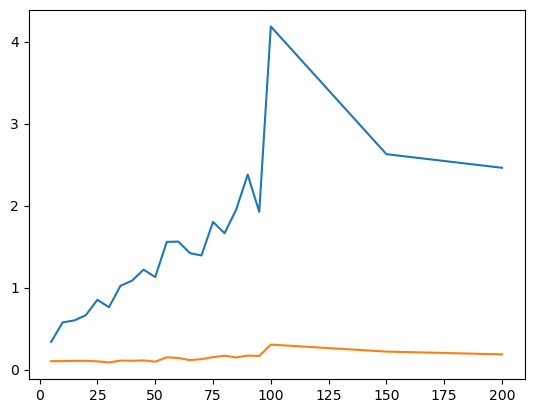

In [45]:

plt.plot(convergence_diag['n_steps'],np.abs(np.array(convergence_diag['norm_error_EGA_Static'])).mean(axis = -1).mean(axis = -1))
plt.plot(convergence_diag['n_steps'],np.abs(np.array(convergence_diag['norm_error_EGA_J_Euler'])).mean(axis = -1).mean(axis = -1))


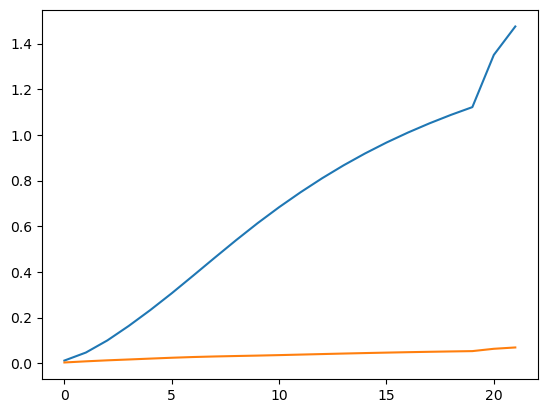

In [47]:
plt.plot(np.abs(np.array(convergence_diag['error_EGA_Static'])).mean(axis = -1).mean(axis = -1))
plt.plot(np.abs(np.array(convergence_diag['error_EGA_J_Euler'])).mean(axis = -1).mean(axis = -1))


In [ ]:
np.array(convergence_diag['time_comp_graph']).mean(axis = -1)/np.array(convergence_diag['time_EGA_static']).mean(axis = -1)

In [ ]:
convergence_diag['n_steps']

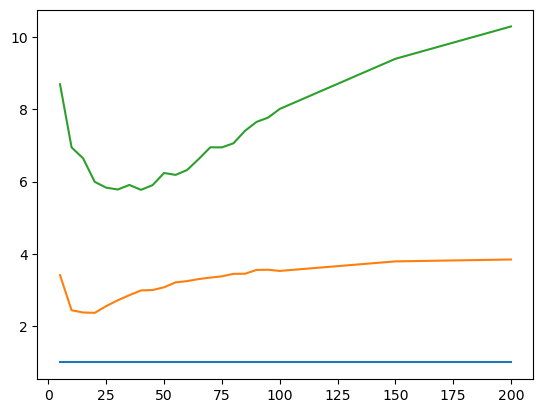

In [39]:
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph']).mean(axis = -1)/np.array(convergence_diag['time_comp_graph']).mean(axis = -1))
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph']).mean(axis = -1)/np.array(convergence_diag['time_EGA_J_Euler']).mean(axis = -1))
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph']).mean(axis = -1)/np.array(convergence_diag['time_EGA_static']).mean(axis = -1))

In [ ]:
np.array(convergence_diag['time_comp_graph'])/np.array(convergence_diag['time_EGA_J_Euler'])

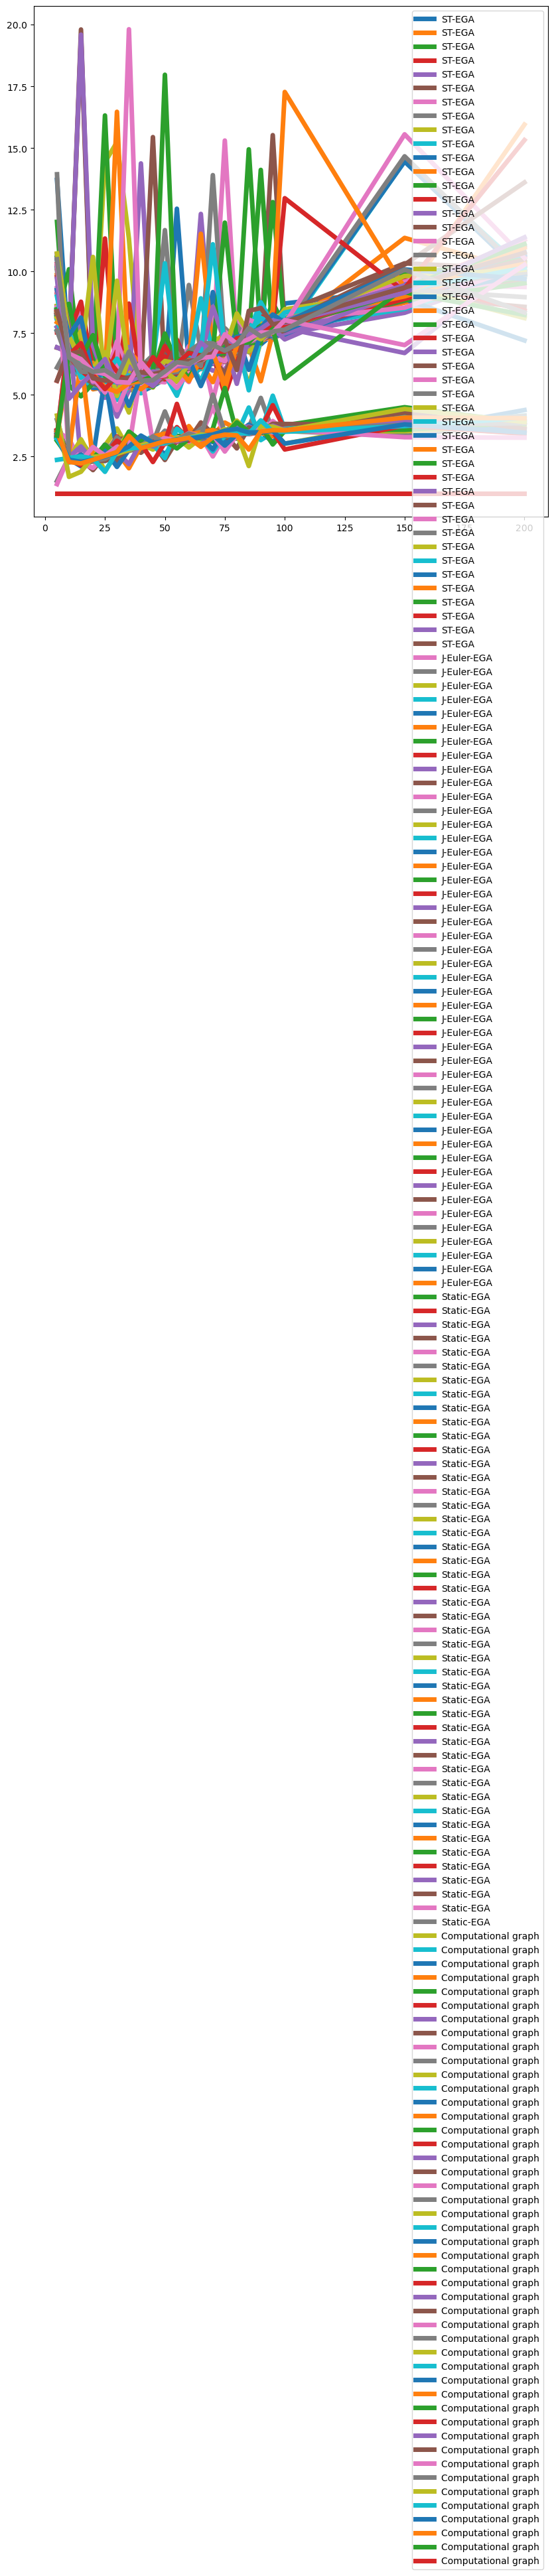

In [48]:
plt.figure(figsize=(10,10))
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph'])/np.array(convergence_diag['time_EGA_ST']), lw = 5, label = 'ST-EGA')
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph'])/np.array(convergence_diag['time_EGA_J_Euler']), lw = 5, label = 'J-Euler-EGA')
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph'])/np.array(convergence_diag['time_EGA_static']), lw = 5, label = 'Static-EGA')
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph'])/np.array(convergence_diag['time_comp_graph']), lw = 5, label = 'Computational graph')
plt.legend()

In [ ]:
convergence_diag['time_EGA_ST']

In [38]:
plt.figure(figsize=(10,10))
plt.loglog(convergence_diag['time_steps'],torch.abs(torch.stack(convergence_diag['error_EGA_ST'])).mean(axis = -1),'*', markersize = 15, lw = 5, label = 'ST-EGA')
plt.loglog(convergence_diag['time_steps'],torch.abs(torch.stack(convergence_diag['error_EGA_Static'])).mean(axis = -1), lw = 5, label = 'Static-EGA')
plt.loglog(convergence_diag['time_steps'],torch.abs(torch.stack(convergence_diag['error_EGA_J_Euler'])).mean(axis = -1), lw = 5, label = 'J-Euler-EGA')
plt.loglog(convergence_diag['time_steps'],50000*np.array(convergence_diag['time_steps'])**2, label = 'Second order', lw = 5)
plt.tick_params(axis='both')
plt.grid()
plt.legend()
plt.xlabel('h')
plt.ylabel('Gradient error')
plt.show()

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

<Figure size 1000x1000 with 0 Axes>